# FrenchC2C FTU Model Bias Analysis

## Import Dependencies

In [1]:
# !pip install researchpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from dataclasses import dataclass

In [5]:
%matplotlib inline

In [6]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

In [7]:
from sklearn.metrics import confusion_matrix

# Custom functions

#### Dataclass for confusion matrix results

In [8]:
@dataclass
class cmatrix:
    name: str
    TP: int
    FP: int
    TN: int
    FN: int    
    PPV: float
    TPR: float
    FDR: float
    FPR: float
    FOR: float
    FNR: float
    NPV: float
    TNR: float

#### Helper function to generate dataclass _cmatrix_

In [9]:
def gen_dataclass(actual, pred, name):
    [TN, FP, FN, TP] = confusion_matrix(actual, pred).ravel()
    

    PPV = TP / (TP + FP)  # positive predictive value
    FDR = FP / (TP + FP)  # false discovery rate
    
    TPR = TP / (TP + FN)  # true positive rate
    FNR = FN / (TP + FN)  # false negative rate
    
    TNR = TN / (TN + FP)  # true negative rate
    FPR = FP / (TN + FP)  # false positive rate

    FOR = FN / (TN + FN)  # false omission rate
    NPV = TN / (TN + FN)  # negative predictive value

    
    return cmatrix(name, TP, FP, TN, FN, PPV, TPR, FDR, FPR, FOR, FNR, NPV, TNR)

#### Extract bias metrics

In [10]:
def bias_metrics(df):
    '''
    - takes dataframe as input
    - returns dataclass whose components are statistical measures from a confusion matrix
    particular to relu, tanh, elu, and leaky relu dataframe series
    '''
    actual = df.target.values
    relu = df.pred_relu.values
    tanh = df.pred_tanh.values
    elu = df.pred_elu.values
    leaky = df.pred_leaky.values
    
    relu = gen_dataclass(actual, relu, "relu")
    tanh = gen_dataclass(actual, tanh, "tanh")
    elu = gen_dataclass(actual, elu, "elu")
    leaky = gen_dataclass(actual, leaky, "leaky")
    
    return relu, tanh, elu, leaky

# Import Data

In [11]:
data = pd.read_parquet("compas_results_mk2_FTU.parquet")

In [12]:
data.head()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,sex,age_cat_25to45,age_cat_over45,age_cat_under25,race_asian,c_charge_degree,score_text_High,score_text_Low,score_text_Medium,v_score_text_High,v_score_text_Low,v_score_text_Medium,event,black,white,hispanic,native,other,target,pred_relu,pred_tanh,pred_elu,pred_leaky
0,25,0,5,0,1,4,-1,1,1,0,5,4,4,32,304,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,1,1
1,35,0,4,0,0,3,-1,0,1,0,4,4,3,9,462,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,1,1,1
2,32,0,4,0,0,1,0,0,0,0,4,3,1,0,1171,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,20,0,10,0,0,0,-1,1,1,1,10,10,0,3,20,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,1,1,1
4,50,0,8,0,2,24,0,1,1,1,8,8,24,32,87,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1


In [13]:
features = list(data.columns[-5:])
features

['target', 'pred_relu', 'pred_tanh', 'pred_elu', 'pred_leaky']

#### Inspect Data

**Note:** The following confusion matrix should return a list of four (4) numbers, with zero (0) false negatives and false positives. Example: array([100, 0, 0, 10])

In [14]:
confusion_matrix(data.target, data.target).ravel()

array([1114,    0,    0,  959])

In [15]:
print("Name\t    Total   TP     FP   TN     FN")
for f in features:
    total = data[f].sum()
    try:
        [tn, fp, fn, tp] = confusion_matrix(data.target, data[f]).ravel()
    except Exception:
        pass
    print(f"{f:10s}: {total:5.0f}  {tp:5.0f} {fp:5.0f} {tn:6.0f} {fn:5.0f}")

Name	    Total   TP     FP   TN     FN
target    :   959    959     0   1114     0
pred_relu :  1026    910   116    998    49
pred_tanh :   981    909    72   1042    50
pred_elu  :   936    847    89   1025   112
pred_leaky:  1028    917   111   1003    42


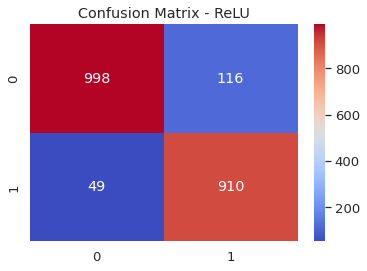

In [16]:
cm_relu = confusion_matrix(data.target, data.pred_relu)
sns.set(font_scale=1.2)
sns.heatmap(cm_relu, annot=True, cmap="coolwarm", robust=True, fmt='g')
plt.title("Confusion Matrix - ReLU")
plt.show()

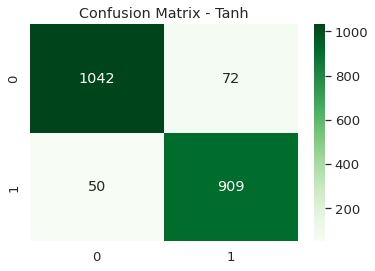

In [17]:
cm_tanh = confusion_matrix(data.target, data.pred_tanh)
sns.set(font_scale=1.2)
sns.heatmap(cm_tanh, annot=True, cmap="Greens", robust=True, fmt='g')
plt.title("Confusion Matrix - Tanh")
plt.show()

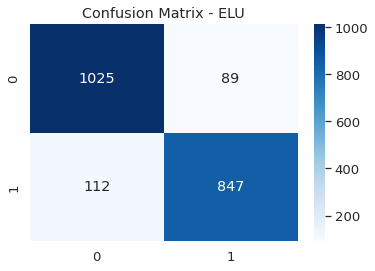

In [18]:
cm_elu = confusion_matrix(data.target, data.pred_elu)
sns.set(font_scale=1.2)
sns.heatmap(cm_elu, annot=True, cmap="Blues", robust=True, fmt='g')
plt.title("Confusion Matrix - ELU")
plt.show()

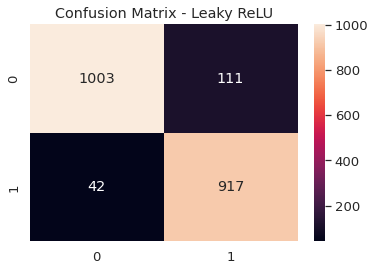

In [19]:
cm_leaky = confusion_matrix(data.target, data.pred_leaky)
sns.set(font_scale=1.2)
sns.heatmap(cm_leaky, annot=True, fmt='g')
plt.title("Confusion Matrix - Leaky ReLU")
plt.show()

## Separate by protected feature

In [20]:
# group A : protected attribute
# group B : other
GroupA = data[data["black"] == 1]
GroupB = data[data["white"] == 0]
attribute = ["black", "white"]

In [21]:
GroupA.shape

(1075, 38)

In [22]:
GroupB.shape

(1376, 38)

In [23]:
data.shape

(2073, 38)

##### Control stats, baseline

In [24]:
Cr, Ct, Ce, Cl = bias_metrics(data)

In [25]:
Ct.TPR

0.9478623566214807

##### Stats for Group A and Group B dataframes

In [26]:
Ar, At, Ae, Al = bias_metrics(GroupA)
Br, Bt, Be, Bl = bias_metrics(GroupB)

In [27]:
At.TPR

0.9609236234458259

# Bias Testing

#### Predictive parity

Compares precision (or positive predictive value, PPV) between group with protected attribute and without protected attribute. In this instance female group with male group

In [28]:
pp = [
    Ar.PPV == Br.PPV,
    At.PPV == Bt.PPV,
    Ae.PPV == Be.PPV,
    Al.PPV == Bl.PPV
]

In [29]:
pp_diff_r = 1 - (min(Ar.PPV,Br.PPV)/ max(Ar.PPV, Br.PPV))
pp_diff_t = 1 - (min(At.PPV, Bt.PPV)/ max(At.PPV, Bt.PPV))
pp_diff_e = 1 - (min(Ae.PPV, Be.PPV)/ max(Ae.PPV, Be.PPV))
pp_diff_l = 1 - (min(Al.PPV, Bl.PPV)/ max(Al.PPV, Bl.PPV))

In [30]:
print("Predictive parity -")
one = "PPV"
two = "FDR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}Difference")
print(f"{Ar.name}\t{pp[0]}\t{Ar.FDR == Br.FDR}\t{Ar.PPV:0.5f}\t{Br.PPV:10.5f}\t{pp_diff_r:0.5f}")
print(f"{At.name}\t{pp[1]}\t{At.FDR == Bt.FDR}\t{At.PPV:0.5f}\t{Bt.PPV:10.5f}\t{pp_diff_t:0.5f}")
print(f"{Ae.name}\t{pp[2]}\t{Ae.FDR == Be.FDR}\t{Ae.PPV:0.5f}\t{Be.PPV:10.5f}\t{pp_diff_e:0.5f}")
print(f"{Al.name}\t{pp[3]}\t{Al.FDR == Bl.FDR}\t{Al.PPV:0.5f}\t{Bl.PPV:10.5f}\t{pp_diff_l:0.5f}")

Predictive parity -
Name	PPV	FDR	PPV        FDR       Difference
relu	False	False	0.87825	   0.87929	0.00118
tanh	False	False	0.92479	   0.92075	0.00437
elu	False	False	0.89175	   0.89396	0.00247
leaky	False	False	0.88103	   0.88388	0.00323


In [31]:
Cr

cmatrix(name='relu', TP=910, FP=116, TN=998, FN=49, PPV=0.8869395711500975, TPR=0.948905109489051, FDR=0.11306042884990253, FPR=0.10412926391382406, FOR=0.04680038204393505, FNR=0.051094890510948905, NPV=0.9531996179560649, TNR=0.895870736086176)

#### Predictive Equality

Also called the False Positive Error Balance, this metric considers compares the false positive rates (FPR) between groups.

In [32]:
pe = [
    Ar.FPR == Br.FPR,
    At.FPR == Bt.FPR,
    Ae.FPR == Be.FPR,
    Al.FPR == Bl.FPR    
]

In [33]:
pe_diff_r = 1-(min(Ar.FPR, Br.FPR)/max(Ar.FPR, Br.FPR))
pe_diff_t = 1-(min(At.FPR, Bt.FPR)/max(At.FPR, Bt.FPR))
pe_diff_e = 1-(min(Ae.FPR, Be.FPR)/max(Ae.FPR, Be.FPR))
pe_diff_l = 1-(min(Al.FPR, Bl.FPR)/max(Al.FPR, Bl.FPR))

In [34]:
print("Predictive equality -")
one = "FPR"
two = "TNR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}\tDifference")
print(f"{Ar.name}\t{pe[0]}\t{Ar.TNR == Br.TNR}\t{Ar.FPR:0.5f}\t{Br.FPR:10.5f}\t{pe_diff_r:0.5f}")
print(f"{At.name}\t{pe[1]}\t{At.TNR == Bt.TNR}\t{At.FPR:0.5f}\t{Bt.FPR:10.5f}\t{pe_diff_t:0.5f}")
print(f"{Ae.name}\t{pe[2]}\t{Ae.TNR == Be.TNR}\t{Ae.FPR:0.5f}\t{Be.FPR:10.5f}\t{pe_diff_e:0.5f}")
print(f"{Al.name}\t{pe[3]}\t{Al.TNR == Bl.TNR}\t{Al.FPR:0.5f}\t{Bl.FPR:10.5f}\t{pe_diff_l:0.5f}")

Predictive equality -
Name	FPR	TNR	FPR        TNR       	Difference
relu	False	False	0.14648	   0.12429	0.15149
tanh	False	False	0.08594	   0.07768	0.09605
elu	False	False	0.12305	   0.10169	0.17353
leaky	False	False	0.14453	   0.12006	0.16934


#### Equal opportunity

Equal Opportunity entails equal false negative rates (FNR) between groups. Mathematically, true postive rates (TPR) should also be equal.

In [35]:
eo = [
    Ar.FNR == Br.FNR,
    At.FNR == Bt.FNR,
    Ae.FNR == Be.FNR,
    Al.FNR == Bl.FNR
]

In [36]:
eo_diff_r = 1 - (min(Ar.FNR, Br.FNR) / max(Ar.FNR, Br.FNR))
eo_diff_t = 1 - (min(At.FNR, Bt.FNR) / max(At.FNR, Bt.FNR))
eo_diff_e = 1 - (min(Ae.FNR, Be.FNR) / max(Ae.FNR, Be.FNR))
eo_diff_l = 1 - (min(Al.FNR, Bl.FNR) / max(Al.FNR, Bl.FNR))

In [37]:
print("Predictive parity -")
one = "FNR"
two = "TPR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}Difference")
print(f"{Ar.name}\t{eo[0]}\t{Ar.TPR == Br.TPR}\t{Ar.FNR:0.5f}\t{Br.FNR:10.5f}\t{eo_diff_r:0.5f}")
print(f"{At.name}\t{eo[1]}\t{At.TPR == Bt.TPR}\t{At.FNR:0.5f}\t{Bt.FNR:10.5f}\t{eo_diff_t:0.5f}")
print(f"{Ae.name}\t{eo[2]}\t{Ae.TPR == Be.TPR}\t{Ae.FNR:0.5f}\t{Be.FNR:10.5f}\t{eo_diff_e:0.5f}")
print(f"{Al.name}\t{eo[3]}\t{Al.TPR == Bl.TPR}\t{Al.FNR:0.5f}\t{Bl.FNR:10.5f}\t{eo_diff_l:0.5f}")

Predictive parity -
Name	FNR	TPR	FNR        TPR       Difference
relu	False	False	0.03908	   0.04042	0.03322
tanh	False	False	0.03908	   0.04341	0.09990
elu	False	False	0.07815	   0.09132	0.14416
leaky	False	False	0.02664	   0.03144	0.15250


#### Statistical Parity

Statistical Parity compares the accuracy of different groups.

In [38]:
Ar_acc = (Ar.TP + Ar.TN) / (Ar.TP + Ar.TN + Ar.FP + Ar.FN)
Br_acc = (Br.TP + Br.TN) / (Br.TP + Br.TN +Br.FP + Br.FN)
r_diff = 1 - (min(Ar_acc, Br_acc) / max(Ar_acc, Br_acc))

In [39]:
At_acc = (At.TP + At.TN) / (At.TP + At.TN + At.FP + At.FN)
Bt_acc = (Bt.TP + Bt.TN) / (Bt.TP + Bt.TN + Bt.FP + Bt.FN)
t_diff = 1 - (min(At_acc, Bt_acc) / max(At_acc, Bt_acc))

In [40]:
Ae_acc = (Ae.TP + Ae.TN) / (Ae.TP + Ae.TN + Ae.FP + Ae.FN)
Be_acc = (Be.TP + Be.TN) / (Be.TP + Be.TN + Be.FP + Be.FN)
e_diff = 1 - (min(Ae_acc, Be_acc) / max(Ae_acc, Be_acc))

In [41]:
Al_acc = (Al.TP + Al.TN) / (Al.TP + Al.TN + Al.FP + Al.FN)
Bl_acc = (Bl.TP + Bl.TN) / (Bl.TP + Bl.TN + Bl.FP + Bl.FN)
l_diff = 1 - (min(Al_acc, Bl_acc) / max(Al_acc, Bl_acc))

In [42]:
sp = [
    Ar_acc == Br_acc,
    At_acc == Bt_acc,
    Ae_acc == Be_acc,
    Al_acc == Bl_acc
]

In [43]:
print("Statistical Parity")
one = f"ACC-{attribute[0][0].capitalize()}"
two = f"ACC-{attribute[1][0].capitalize()}"
print(f"Name\tEqual\t{one:11s}{two}\tDifference")
print(f"{Ar.name}\t{sp[0]}\t{Ar_acc:0.5f}\t{Br_acc:10.5f}\t{r_diff:0.5f}")
print(f"{At.name}\t{sp[1]}\t{At_acc:0.5f}\t{Bt_acc:10.5f}\t{t_diff:0.5f}")
print(f"{Ae.name}\t{sp[2]}\t{Ae_acc:0.5f}\t{Be_acc:10.5f}\t{e_diff:0.5f}")
print(f"{Al.name}\t{sp[3]}\t{Al_acc:0.5f}\t{Bl_acc:10.5f}\t{l_diff:0.5f}")

Statistical Parity
Name	Equal	ACC-B      ACC-W	Difference
relu	False	0.90977	   0.91642	0.00726
tanh	False	0.93860	   0.93895	0.00037
elu	False	0.90047	   0.90334	0.00319
leaky	False	0.91721	   0.92297	0.00624


In [44]:
Aset = GroupA.iloc[:,-5:]
Bset = GroupB.iloc[:,-5:]
base = data.iloc[:,-5:]

#### Compare Variances

In [45]:
np.var(Aset)

target        0.249437
pred_relu     0.244668
pred_tanh     0.248048
pred_elu      0.248286
pred_leaky    0.243821
dtype: float64

In [46]:
np.var(Bset)

target        0.249789
pred_relu     0.249112
pred_tanh     0.249981
pred_elu      0.249957
pred_leaky    0.248977
dtype: float64

In [47]:
np.var(base)

target        0.248602
pred_relu     0.249974
pred_tanh     0.249283
pred_elu      0.247650
pred_leaky    0.249983
dtype: float64

In [48]:
np.var(base) == np.var(Aset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [49]:
np.var(base) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [50]:
np.var(Aset) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

# Hypothesis Testing

### Actual results

#### Control and Group A

In [51]:
print(f"Control and {attribute[0].capitalize()}")
rp.ttest(base["target"], Aset["target"], equal_variances=False)[1][2:4]

Control and Black


,Welch's t-test,results
2,t =,-3.2559
3,Two side test p value =,0.0011


#### Control and Group B

In [52]:
print(f"Baseline and {attribute[1].capitalize()}")
rp.ttest(base["target"], Bset["target"], equal_variances=False)[1][2:4]

Baseline and White


,Welch's t-test,results
2,t =,-1.3157
3,Two side test p value =,0.1884


#### Group A and Group B

In [53]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")
rp.ttest(Aset["target"], Bset["target"], equal_variances=False)[1][2:4]

Black and White


,Welch's t-test,results
2,t =,1.8804
3,Two side test p value =,0.0602


### Tanh Results

#### Control and Group A

In [54]:
print(f"Control and {attribute[0].capitalize()}")
rp.ttest(base["pred_tanh"], Aset["pred_tanh"], equal_variances=False)[1][2:4]

Control and Black


,Welch's t-test,results
2,t =,-3.7861
3,Two side test p value =,0.0002


#### Control and Group B

In [55]:
print(f"Control and {attribute[1].capitalize()}")
rp.ttest(base["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][2:4]

Control and White


,Welch's t-test,results
2,t =,-1.7912
3,Two side test p value =,0.0734


#### Group A and Group B

In [56]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")
rp.ttest(Aset["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][2:4]

Black and White


,Welch's t-test,results
2,t =,1.9603
3,Two side test p value =,0.0501


### ELU Results

#### Control and Group A

In [57]:
print(f"Control and {attribute[0].capitalize()}")
rp.ttest(Aset["pred_elu"], base["pred_elu"], equal_variances=False)[1][2:4]

Control and Black


,Welch's t-test,results
2,t =,4.7993
3,Two side test p value =,0.0000


#### Control and Group B

In [58]:
print(f"Control and {attribute[1].capitalize()}")
rp.ttest(base["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][2:4]

Control and White


,Welch's t-test,results
2,t =,-2.4161
3,Two side test p value =,0.0157


#### Group A and Group B

In [59]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")
rp.ttest(Aset["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][2:4]

Black and White


,Welch's t-test,results
2,t =,2.3589
3,Two side test p value =,0.0184


### Difference tests

**NOTE:** The variables of this test are dependent on the names of the particular dataset features.

In [60]:
rp.difference_test("target ~ C(black)",
                   data=data,
                   equal_variances=False).conduct()

(       Name       N      Mean  Variance        SD        SE  95% Conf.  \
 0         0  2061.0  0.192140  0.155297  0.394078  0.008680   0.175116   
 1         1  2071.0  0.271849  0.198043   0.44502  0.009779   0.252672   
 2  combined  4132.0  0.232091  0.178268  0.422218  0.006568   0.219213   
 3      diff         -0.079710                      0.013076  -0.105345   
 
    Interval  
 0  0.209163  
 1  0.291027  
 2  0.244969  
 3 -0.054074  ,
              Welch's t-test       Results
 0        Difference (0 - 1) -7.970961e-02
 1      Degrees of freedom =  4.076951e+03
 2                       t = -6.095952e+00
 3  Two sided test p-value =  1.188777e-09
 4  Difference < 0 p-value =  5.943634e-10
 5  Difference > 0 p-value =  1.000000e+00)

In [61]:
rp.difference_test("target ~ C(white)",
                   data=data,
                   equal_variances=False).conduct()

(       Name       N      Mean  Variance        SD        SE  95% Conf.  \
 0         0  2071.0  0.322549  0.218617  0.467565  0.010274   0.302400   
 1         1  2061.0  0.141194  0.121317  0.348306  0.007672   0.126147   
 2  combined  4132.0  0.232091  0.178268  0.422218  0.006568   0.219213   
 3      diff          0.181356                      0.012823   0.156216   
 
    Interval  
 0  0.342699  
 1  0.156240  
 2  0.244969  
 3  0.206496  ,
              Welch's t-test       Results
 0        Difference (0 - 1)  1.813559e-01
 1      Degrees of freedom =  3.828284e+03
 2                       t =  1.414324e+01
 3  Two sided test p-value =  2.637963e-44
 4  Difference < 0 p-value =  1.000000e+00
 5  Difference > 0 p-value =  0.000000e+00)

## Selection Rates and Impact

#### Baseline

In [62]:
col = "target"
sr_A = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_base = min(sr_A, sr_B) / max(sr_A, sr_B)

In [63]:
print("Selection Rate and Impact - control")
print(f"{attribute[0].capitalize()} :\t{sr_A:0.5f}")
print(f"{attribute[1].capitalize()} :\t{sr_B:0.5f}")
print(f"Impact:\t{impact_base:0.5f}")

Selection Rate and Impact - control
Black :	0.27159
White :	0.32224
Impact:	0.84281


#### ReLU

In [64]:
col = "pred_relu"
sr_A_relu = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_relu = Bset[Bset[col] == 1].shape[0] / data.shape[0]

try:
    impact_relu = min(sr_A_relu, sr_B_relu) / max(sr_A_relu, sr_B_relu)
except ZeroDivisionError:
    print(f"sr_A_relu: {sr_A_relu}\nsr_B_relu: {sr_B_relu}\nimpact set to 0")
    impact_relu = 0

In [65]:
print("Selection Rate and Impact - ReLU")
print(f"{attribute[0].capitalize()} :\t{sr_A_relu:0.5f}")
print(f"{attribute[1].capitalize()} :\t{sr_B_relu:0.5f}")
print(f"Impact:\t{impact_relu:0.5f}")

Selection Rate and Impact - ReLU
Black :	0.29715
White :	0.35166
Impact:	0.84499


#### Tanh

In [66]:
col = "pred_tanh"
sr_A_tanh = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_tanh = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_tanh = min(sr_A_tanh, sr_B_tanh) / max(sr_A_tanh, sr_B_tanh)

In [67]:
print("Selection Rate and Impact - Tanh")
print(f"{attribute[0].capitalize()} :\t{sr_A_tanh:0.5f}")
print(f"{attribute[1].capitalize()} :\t{sr_B_tanh:0.5f}")
print(f"Impact:\t{impact_tanh:0.5f}")

Selection Rate and Impact - Tanh
Black :	0.28220
White :	0.33478
Impact:	0.84294


#### ELU

In [68]:
col = "pred_elu"
sr_A_elu = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_elu = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_elu = min(sr_A_elu, sr_B_elu) / max(sr_A_elu, sr_B_elu)

In [69]:
print("Selection Rate and Impact - elu")
print(f"{attribute[0].capitalize()} :\t{sr_A_elu:0.5f}")
print(f"{attribute[1].capitalize()} :\t{sr_B_elu:0.5f}")
print(f"Impact:\t{impact_elu:0.5f}")

Selection Rate and Impact - elu
Black :	0.28075
White :	0.32754
Impact:	0.85714


#### Leaky ReLU

In [70]:
col = "pred_leaky"
sr_A_leaky = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_leaky = Bset[Bset[col] == 1].shape[0] / data.shape[0]

try:
    impact_leaky = min(sr_A_leaky, sr_B_leaky) / max(sr_A_leaky, sr_B_leaky)
except ZeroDivisionError:
    print(f"sr_A_leaky: {sr_A_leaky}\nsr_B_leaky: {sr_B_leaky}\nimpact set to 0")
    impact_leaky = 0

In [71]:
print("Selection Rate and Impact - leaky")
print(f"{attribute[0].capitalize()} :\t{sr_A_leaky:0.5f}")
print(f"{attribute[1].capitalize()} :\t{sr_B_leaky:0.5f}")
print(f"Impact:\t{impact_leaky:0.5f}")

Selection Rate and Impact - leaky
Black :	0.30005
White :	0.35311
Impact:	0.84973


# Results

In [72]:
print(" "*12, "Selection Rate and Impact")
print("Group\tBase\t ReLU\t  Tanh\t   ELU\t    Leaky")
print(f"{attribute[0].capitalize()}: {sr_A:0.5f}  {sr_A_relu:0.5f}  {sr_A_tanh:0.5f}  {sr_A_elu:0.5f}  {sr_A_leaky:0.5f}")
print(f"{attribute[1].capitalize()} : {sr_B:0.5f}  {sr_B_relu:0.5f}  {sr_B_tanh:0.5f}  {sr_B_elu:0.5f}  {sr_B_leaky:0.5f}")
print(f"Impact: {impact_base:0.5f}  {impact_relu:0.5f}  {impact_tanh:0.5f}  {impact_elu:0.5f}  {impact_leaky:0.5f}")

             Selection Rate and Impact
Group	Base	 ReLU	  Tanh	   ELU	    Leaky
Black: 0.27159  0.29715  0.28220  0.28075  0.30005
White : 0.32224  0.35166  0.33478  0.32754  0.35311
Impact: 0.84281  0.84499  0.84294  0.85714  0.84973


In [73]:
print(" "*12, "Bias Metrics")
print("*" * 37)
labels = ["Func.","PP","PE","EO","SP"]
fns = ["ReLU", "Tanh", "ELU", "Leaky"]
print(f"{labels[0]}\t{labels[1]}\t{labels[2]}\t{labels[3]}\t{labels[4]}")
for i in range(0,4):
    print(f"{fns[i]}\t{pp[i]}\t{pe[i]}\t{eo[i]}\t{sp[i]}")


print("\n\nLegend")
print(" - PP : predictive parity\n" +
      " - PE : predictive equality\n" +
      " - EO : equal opportunity\n" +
      " - SP : statistical parity")

             Bias Metrics
*************************************
Func.	PP	PE	EO	SP
ReLU	False	False	False	False
Tanh	False	False	False	False
ELU	False	False	False	False
Leaky	False	False	False	False


Legend
 - PP : predictive parity
 - PE : predictive equality
 - EO : equal opportunity
 - SP : statistical parity


In [74]:
features

['target', 'pred_relu', 'pred_tanh', 'pred_elu', 'pred_leaky']

# Similarity Metrics

#### Import Metrics Libraries

In [75]:
import Levenshtein as lev
from pyjarowinkler import distance as dist

#### Convert to string

In [76]:
Astr = [[""] * Aset.shape[0]] * Aset.shape[1]
Bstr = [[""] * Bset.shape[0]] * Bset.shape[1]

In [77]:
for f in range(len(features)):
    Astr[f] = ''.join(GroupA[features[f]].values.astype('int').astype('str'))
    Bstr[f] = ''.join(GroupB[features[f]].values.astype('int').astype('str'))

#### Test defaults
Levenshtein result should be 0

In [78]:
lev.distance(Astr[1], Astr[1])

0

Jaro similarity result should be 1.0

In [79]:
dist.get_jaro_distance(Astr[1], Astr[1])

1.0

In [80]:
for i, f in enumerate(features):
    print(f"{f:10s} : {i}")

target     : 0
pred_relu  : 1
pred_tanh  : 2
pred_elu   : 3
pred_leaky : 4


In [81]:
print("Similarity and Distance Metrics\n" \
      f"     Between {attribute[0].capitalize()} and {attribute[1].capitalize()}")
print("*" * 46)
print("Function\tLev.\tJaro\t  Jaro-Winkler")
for i, f in enumerate(features):
    print(f"{f:10s}:\t{lev.distance(Astr[i], Bstr[i])}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=False):7.5f}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=True):9.5f}")
    

Similarity and Distance Metrics
     Between Black and White
**********************************************
Function	Lev.	Jaro	  Jaro-Winkler
target    :	301	0.84584	  0.91000
pred_relu :	301	0.84708	  0.91000
pred_tanh :	301	0.84615	  0.91000
pred_elu  :	301	0.84429	  0.91000
pred_leaky:	301	0.84615	  0.91000


# Distribution Tests

Test results for shape of distribution

In [82]:
from scipy.stats import binom, chisquare, kstest

In [83]:
for f in features:
    test = data[f]

    x = test.values
    n = test.sum()
    p = n / test.shape[0]

    stat, pval = kstest(rvs=x, cdf=binom.cdf(x, n, p))
    print(f"Binom  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if stat > 0.5:
        print("  X")
    else:
        print()

    stat, pval = kstest(rvs=x, cdf='norm')
    print(f"Norm   - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")    
    if stat > 0.5:
        print("  X")
    else:
        print()
    
    freqB = data.target.sum()
    stat, pval = chisquare([n, freqB])
    print(f"Chi^2  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if pval > stat:
        print("  same as actual\n")
    else:
        print("\n")

Binom  - target    :       0.53739    0.00  X
Norm   - target    :       0.50000    0.00
Chi^2  - target    :       0.00000    1.00  same as actual

Binom  - pred_relu :       0.50507    0.00  X
Norm   - pred_relu :       0.50000    0.00
Chi^2  - pred_relu :       2.26146    0.13

Binom  - pred_tanh :       0.52677    0.00  X
Norm   - pred_tanh :       0.50000    0.00
Chi^2  - pred_tanh :       0.24948    0.62  same as actual

Binom  - pred_elu  :       0.54848    0.00  X
Norm   - pred_elu  :       0.50000    0.00
Chi^2  - pred_elu  :       0.27916    0.60  same as actual

Binom  - pred_leaky:       0.50410    0.00  X
Norm   - pred_leaky:       0.50000    0.00
Chi^2  - pred_leaky:       2.39607    0.12

